In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installedimport numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import graphutil
# import custom_lstm_cell 
# import evolve_graph_network as egcn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

id_time=["txId", "time_step"]
feature_names = ['feature_'+str(i) for i in range(1,166)]
column_names = id_time + feature_names
elliptic_classes = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
elliptic_classes.columns = ['txId', 'class_label']
elliptic_edgelist = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
elliptic_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', names=column_names)

#### Make directories to hold model

In [3]:
import shutil
shutil.os.mkdir('/kaggle/working/base_model')
shutil.os.mkdir('/kaggle/working/retask_model')
shutil.os.mkdir('/kaggle/working/finetune_model')

# Graph Loading:
#### Determine the time steps, and then create and store graph at each time step
* here we load 17 out of 49 time steps, and then create graph respectively

In [5]:
time_steps = list(range(1,17))
graphs = []
for time_step in time_steps:
    extract_nodes = list(set(elliptic_features[elliptic_features['time_step']==time_step]['txId'].values.tolist()))
    edgelist_extract = elliptic_edgelist[elliptic_edgelist['txId1'].isin(extract_nodes) & elliptic_edgelist['txId2'].isin(extract_nodes)].values.tolist()
    edgelist = [tuple(row) for row in edgelist_extract]
    G = nx.DiGraph()
    G.add_edges_from(edgelist)
    graphs.append(G)
extract_nodes = list(set(elliptic_features[elliptic_features['time_step'].isin(time_steps)]['txId'].values.tolist()))

# Data Preparation:
#### Prepare nodes and corresponding labels from database for base prediction model training
* This dataset is for an unsupervised learning procedure so as to create the base model. 
* Here we are not going to actually use this input dataset, because we will re-load a pretrained base model that is trained and uploaded from a local computer. 
* However I put it here as an example.

In [6]:
elliptic_classes_ext = elliptic_classes[elliptic_classes['txId'].isin(extract_nodes) & elliptic_classes['class_label'].isin(['1','2'])].reset_index().drop(columns=['index'])
node_list = [node[0] for node in elliptic_classes_ext.values.tolist()]

np.random.seed(1234)
nodes_num = len(node_list)
permutation_indices = np.random.permutation(nodes_num).tolist()
permutation_nodes = [node_list[x] for x in permutation_indices]

train_num = int(nodes_num*0.8)
test_num = int(nodes_num*0.2)

data_predict ={'features': {'dataframe': elliptic_features,
                            'drop_columns':['time_step']}, 
               'train_nodes':  permutation_nodes[:train_num],
               'test_nodes':   permutation_nodes[train_num:(train_num+test_num)],
               'node_column':  'txId'}

print("train num:", train_num, "| test num:",test_num)

train num: 12835 | test num: 3208


#### Prepare nodes and corresponding labels from database for retask and finetune classification model training
* This dataset has been manually re-balanced and is for a semi-supervised learning procedure to create a model to classify illicit and licit transactions
* This dataset is a simplified version of random under-sampling technique for re-balancing dataset.
* I am not going to use this dataset input either, because a dynamic random under-sampling technique is employed in the training procedure.

In [7]:
elliptic_classes_ext = elliptic_classes[elliptic_classes['txId'].isin(extract_nodes) & elliptic_classes['class_label'].isin(['1','2'])].reset_index().drop(columns=['index'])
label_licit = elliptic_classes_ext[elliptic_classes_ext['class_label']=='2']
label_illicit = elliptic_classes_ext[elliptic_classes_ext['class_label']=='1']
num_illicit = len(label_illicit)
label_licit_sample = label_licit.sample(n=num_illicit, random_state=1)
label_df_balance = pd.concat([label_licit_sample, label_illicit], ignore_index=True)

node_list = [node[0] for node in label_df_balance.values.tolist()]

np.random.seed(1234)
nodes_num = len(node_list)
permutation_indices = np.random.permutation(nodes_num).tolist()
permutation_nodes = [node_list[x] for x in permutation_indices]
elliptic_classes_ext_reindex = label_df_balance.reindex(permutation_indices)
permutation_labels = [(float(node[1])-1) for node in elliptic_classes_ext_reindex.values.tolist()]
permutation_labels = np.expand_dims(permutation_labels,1)

train_num = int(nodes_num*0.8)
test_num = int(nodes_num*0.2)

data_classify ={'features': {'dataframe': elliptic_features,
                             'drop_columns':['time_step']}, 
                'train_nodes':  permutation_nodes[:train_num],
                'train_labels': permutation_labels[:train_num],
                'test_nodes':   permutation_nodes[train_num:(train_num+test_num)],
                'test_labels':  permutation_labels[train_num:(train_num+test_num)],
                'node_column':  'txId'}

print("num train:", train_num, "| num test:", test_num)

num train: 2048 | num test: 512


#### Prepare data to enable random under-sampling strategy so as to re-blance dataset during training and testing procedure
* This dataset input is for a semi-supervised learning procedure to create a model to classify illicit and licit transactions, but in the learning procedure a random under-sampling technique has been adopted.

In [8]:
data_classify_rus ={'features': {'dataframe': elliptic_features,
                                 'drop_columns':['time_step']}, 
                    'data_label': {'dataframe': elliptic_classes,
                                   'time_steps':time_steps},
                    'node_column': 'txId'}

# Model Initialisation
#### Initialise Dynamic Evolving Graph Convolutional Neural Network

In [8]:
tf.compat.v1.disable_eager_execution()
GCN = egcn.evolve_graph_conv_nn(batch_size=70, 
                                neighbor_samples=[20,10], 
                                num_hiddens=[20,20], 
                                num_features=165, 
                                num_labels=1,
                                seq_len = len(time_steps)-1)

/cpu:0
Binary Classification Detected: Sigmoid Enabled


### Phase 1: Un-supervised Base Prediction Model Phase
#### Start training base prediction model
* You can start training base prediction model here. This model is to predict feature of each node on the next time step by using its node embeddings on the previous time steps
* In this kernel we disabled the base prediction model training process, because a pre-trained one will be loaded instead

In [9]:
#losses_base = GCN.train_evolve_gcn_predict(data_predict, 
#              graphs, 100, verbose=False,
#              save='/kaggle/working/base_model/base_evolve_gcn.ckpt')

#### Reviewing Cross Entropy Losses and Accuracy of Base Prediction Model culminating over Epoches

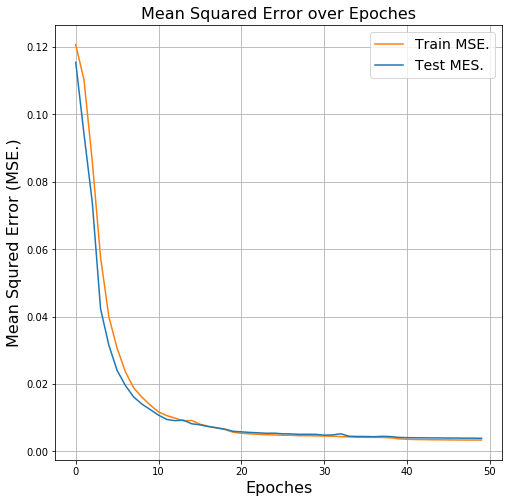

In [10]:
#training_mse = losses_base['training_losses']
#testing_mse = losses_base['testing_losses']
training_mse = np.load("/kaggle/input/evolve-gcn-base-model/gcn_training_mse.npy").tolist()
testing_mse = np.load("/kaggle/input/evolve-gcn-base-model/gcn_testing_mse.npy").tolist()

fig, ax_mse = plt.subplots(1, 1, figsize=(8, 8))
ax_mse.set_ylabel("Mean Squred Error (MSE.)", fontsize=16)
ax_mse.set_xlabel("Epoches", fontsize=16)
ax_mse.plot(training_mse, 'C1', label="Train MSE.")
ax_mse.plot(testing_mse, 'C0', label="Test MES.")
ax_mse.grid()
ax_mse.set_title('Mean Squared Error over Epoches', fontsize=16)
ax_mse.legend(loc="upper right", prop=dict(size=14))
fig.show()

### Phase 2: Semi-supervised Re-Task Model Phase
#### Start training Re-Task semi-supervised classification model
* The base model is loaded as a pretrained model, which is trained and uploaded from local computer. Because it is a time consuming process, but only need do it once.
* For imbalanced dataset (1280 records of illicit transaction ~ approx. 8%, but 14763 records of licit transaction ~ approx. 92%), A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to loss of information. But if the examples of the majority class are near to others, this method might yield good results.
* In Re-Task phase, this simple under-sampling technique is implemented to under-sample the majority class randomly and uniformly in every 5 epoches.
* In Re-Task phase, by setting ```retask = True``` in function ```train_evolve_gcn_classify(...)```, the weights of each layer in GCN has been locked up, except for the Dense Classification Layers.

In [11]:
losses_retask = GCN.train_evolve_gcn_classify(data_classify_rus, 
                graphs, 50, verbose=False,
                pretrain_model = '/kaggle/input/evolve-gcn-base-model/base_evolve_gcn.ckpt',
                #'/kaggle/working/base_model/base_evolve_gcn.ckpt',
                save='/kaggle/working/retask_model/retask_evolve_gcn.ckpt',
                retask = True)

Loading Model ...
Pre-trained Model is Loaded Successfully
start training ...
Random Under-Sampling Engaged
Average training loss for Epoch 0 : 0.46828715  | training accuracy: 0.78719212
Average  testing loss for Epoch 0 : 0.34797455  |  testing accuracy: 0.83877551
Average training loss for Epoch 1 : 0.32841652  | training accuracy: 0.88226601
Average  testing loss for Epoch 1 : 0.30471713  |  testing accuracy: 0.86734694
Average training loss for Epoch 2 : 0.28359342  | training accuracy: 0.90147783
Average  testing loss for Epoch 2 : 0.27112716  |  testing accuracy: 0.89591837
Average training loss for Epoch 3 : 0.25216668  | training accuracy: 0.90837438
Average  testing loss for Epoch 3 : 0.24964736  |  testing accuracy: 0.91020408
Average training loss for Epoch 4 : 0.23798291  | training accuracy: 0.91182266
Average  testing loss for Epoch 4 : 0.24721731  |  testing accuracy: 0.91632653
Average training loss for Epoch 5 : 0.24135805  | training accuracy: 0.91477833
Average  tes

#### Reviewing Cross Entropy Losses and Accuracy of Re-Task Model culminating over Epoches
* Variance is the amount that the estimate of the target function will change if different training data was used. The target function is estimated from the training data by a machine learning algorithm, so we should expect the algorithm to have some variance. Ideally, it should not change too much from one training dataset to the next, meaning that the algorithm is good at picking out the hidden underlying mapping between the inputs and the output variables.
>* Low Variance: Suggests small changes to the estimate of the target function with changes to the training dataset.
>* High Variance: Suggests large changes to the estimate of the target function with changes to the training dataset.
* In Re-Task Phase, High Variance has been observed, because Random Under-Sampling technique will change the sample of nodes for training in every epoch.  

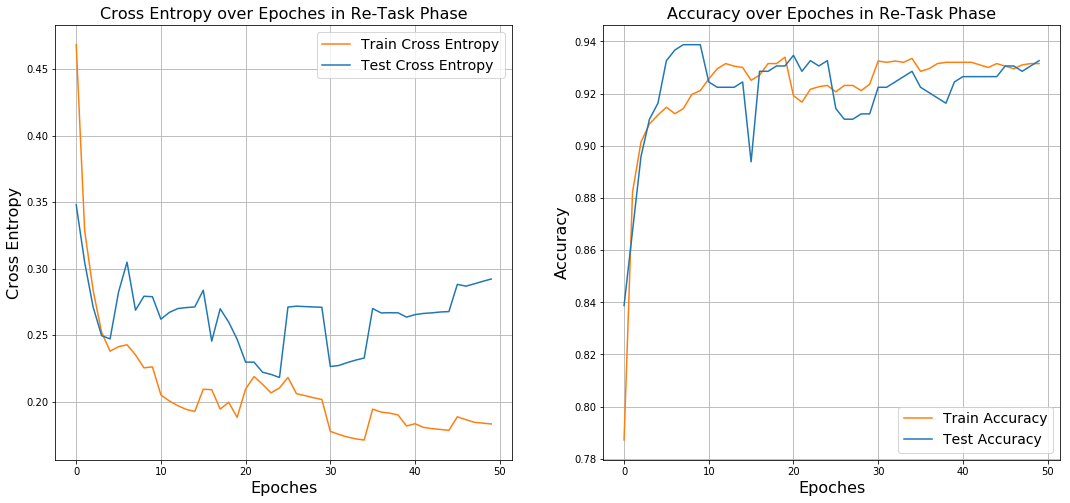

In [12]:
training_losses = losses_retask['training_losses']
training_accuracy = losses_retask['training_acces']

testing_losses = losses_retask['testing_losses']
testing_accuracy = losses_retask['testing_acces']

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(18, 8))

ax_loss.set_ylabel("Cross Entropy", fontsize=16)
ax_loss.set_xlabel("Epoches", fontsize=16)
ax_loss.set_title("Cross Entropy over Epoches in Re-Task Phase", fontsize=16)
ax_loss.plot(training_losses, 'C1', label="Train Cross Entropy")
ax_loss.plot(testing_losses, 'C0', label="Test Cross Entropy")
ax_loss.legend(loc="upper right", prop=dict(size=14))
ax_loss.grid()

ax_acc.set_ylabel("Accuracy", fontsize=16)
ax_acc.set_xlabel("Epoches", fontsize=16)
ax_acc.set_title("Accuracy over Epoches in Re-Task Phase", fontsize=16)
ax_acc.plot(training_accuracy, 'C1', label="Train Accuracy")
ax_acc.plot(testing_accuracy, 'C0', label="Test Accuracy")
ax_acc.legend(loc="lower right", prop=dict(size=14))
ax_acc.grid()

fig.show()

#### Use Feedforward to compute class scores for whole dataset
* Get training and testing splits of nodes from model training procedure, adopt feedforward and load trained model and then use nodes being used in previous training procedure to systematically evaluate the model performance.

In [13]:
train_nodes_set = losses_retask['training_nodes']
test_nodes_set = losses_retask['testing_nodes']

train_node_label = elliptic_classes[elliptic_classes['txId'].isin(train_nodes_set)].reset_index().drop(columns=['index'])
test_node_label = elliptic_classes[elliptic_classes['txId'].isin(test_nodes_set)].reset_index().drop(columns=['index'])

train_nodes =  [node[0] for node in train_node_label.values.tolist()]
train_labels = [(float(node[1])-1) for node in train_node_label.values.tolist()]

test_nodes =  [node[0] for node in test_node_label.values.tolist()]
test_labels = [(float(node[1])-1) for node in test_node_label.values.tolist()]

train_data = {'features': {'dataframe': elliptic_features,
                           'drop_columns':['time_step']}, 
              'nodes':  train_nodes,
              'node_column':  'txId'}

test_data = {'features': {'dataframe': elliptic_features,
                          'drop_columns':['time_step']}, 
             'nodes':  test_nodes,
             'node_column':  'txId'}

rt_train_class_socres = GCN.feedforward(train_data, graphs, 
                        model_path='/kaggle/working/retask_model/retask_evolve_gcn.ckpt')

rt_test_class_socres  = GCN.feedforward(test_data, graphs, 
                        model_path='/kaggle/working/retask_model/retask_evolve_gcn.ckpt')

Loading Model ...
Model is Loaded Successfully



Loading Model ...
Model is Loaded Successfully


#### Random under-sampling for results of majority class to make Receiver Operating Characteristic (ROC) more sensible
* A simple under-sampling technique is to under-sample results of the majority class randomly and uniformly.
* The Receiver operating characteristic (ROC) curve is the typical tool for assessing the performance of machine learning algorithms, but it actually does not measure well for imbalanced data.
* The Receiver operating characteristic (ROC) curves plot FPR vs. TPR. Because TPR only depends on positives (licit transactions), ROC curves do not measure the effects of negatives (illicit transaction). The area under the ROC curve (AUC) assesses overall classification performance. AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.

In [14]:
from random import sample 
train_scores = [x[0] for x in rt_train_class_socres]
test_scores = [x[0] for x in rt_test_class_socres]

train_scores_illicit = [train_scores[i] for i, label in enumerate(train_labels) if label == 0]
train_scores_licit = [train_scores[i] for i, label in enumerate(train_labels) if label == 1]
train_scores_licit_sample = sample(train_scores_licit, len(train_scores_illicit))

test_scores_illicit = [test_scores[i] for i, label in enumerate(test_labels) if label == 0]
test_scores_licit = [test_scores[i] for i, label in enumerate(test_labels) if label == 1]
test_scores_licit_sample = sample(test_scores_licit, len(test_scores_illicit))

y_train_illicit = np.zeros(len(train_scores_illicit))
y_train_licit_sample = np.ones(len(train_scores_licit_sample))
y_test_illicit = np.zeros(len(test_scores_illicit))
y_test_licit_sample = np.ones(len(test_scores_licit_sample))

scores_train_illicit = np.array(train_scores_illicit)
scores_train_licit_sample = np.array(train_scores_licit_sample)
scores_test_illicit = np.array(test_scores_illicit)
scores_test_licit_sample = np.array(test_scores_licit_sample)

scores_train = np.concatenate([scores_train_illicit, scores_train_licit_sample])
scores_test  = np.concatenate([scores_test_illicit,  scores_test_licit_sample])

y_train = np.concatenate([y_train_illicit, y_train_licit_sample])
y_test  = np.concatenate([y_test_illicit,  y_test_licit_sample])

#### Classification output quality evaluations of Re-Task Model
* Receiver operating characteristic (ROC) metric to evaluate classifier output quality of retask classification model.
* Precision-Recall (PR) metric to evaluate classifier output quality of retask classification model. Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve.

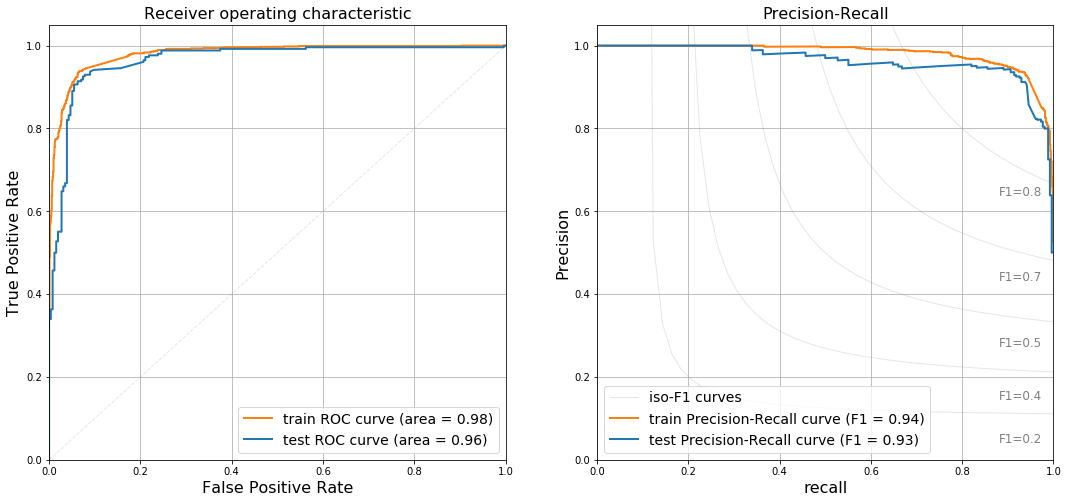

In [15]:
fpr_train, tpr_train, thresholds_train_roc = metrics.roc_curve(y_train+1, scores_train, pos_label=2)
fpr_test, tpr_test, thresholds_test_roc = metrics.roc_curve(y_test+1, scores_test, pos_label=2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

precision_train, recall_train, thresholds_train_pr = metrics.precision_recall_curve(y_train, scores_train)
precision_test, recall_test, thresholds_test_pr = metrics.precision_recall_curve(y_test, scores_test)
f1_train = max(2 * (precision_train * recall_train) / (precision_train + recall_train))
f1_test = max(2 * (precision_test * recall_test) / (precision_test + recall_test))

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 8))
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=16)
ax_roc.set_ylabel('True Positive Rate', fontsize=16)
ax_roc.plot(fpr_train, tpr_train, color='C1',
            lw=2, label='train ROC curve (area = %0.2f)' % roc_auc_train)
ax_roc.plot(fpr_test, tpr_test, color='C0',
            lw=2, label='test ROC curve (area = %0.2f)' % roc_auc_test)
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', alpha=0.2)
ax_roc.set_title('Receiver operating characteristic', fontsize=16)
ax_roc.legend(loc="lower right", prop=dict(size=14))
ax_roc.grid()

lines = []
labels = []
f_scores = np.linspace(0.2, 0.8, num=5)
for f_score in f_scores:
    x = np.linspace(0.001, 1)
    y = f_score * x / (2 * x - f_score)
    l, = ax_pr.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2, lw=1)
    ax_pr.annotate('F1={0:0.1f}'.format(f_score), xy=(0.88, y[45] - 0.07), color='gray', size=12)
lines.append(l)
labels.append('iso-F1 curves')

l, = ax_pr.plot(recall_train, precision_train, color='C1',lw=2)
lines.append(l)
labels.append('train Precision-Recall curve (F1 = %0.2f)' % f1_train)

l, = ax_pr.plot(recall_test, precision_test, color='C0', lw=2)
lines.append(l)
labels.append('test Precision-Recall curve (F1 = %0.2f)' % f1_test)

ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlabel('recall', fontsize=16)
ax_pr.set_ylabel('Precision', fontsize=16)
ax_pr.set_title('Precision-Recall', fontsize=16)
ax_pr.legend(lines, labels, loc="lower left", prop=dict(size=14))
ax_pr.grid()

fig.show()

### Phase 3: Semi-Supervised Fine-Tune Model Phase
#### Start training finetune semi-supervised classification model
* The re-task model is loaded as a pretrained model, which is trained and uploaded from local computer. Because it is a time consuming process, but only need do it once.
* For skewed dataset (1280 records of illicit transaction ~ approx. 8%, but 14763 records of licit transaction ~ approx. 92%), A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to loss of information. But if the examples of the majority class are near to others, this method might yield good results.
* In finetune phase, this simple under-sampling technique is implemented to under-sample the majority class randomly and uniformly in every 5 epoches.
* In finetune phase, ```retask = False``` is defaultly setted in function ```train_evolve_gcn_classify(...)```, by omiting property ```retask``` in the inputs all weights in the model have been unlocked.

In [16]:
if ('train_nodes' in data_classify_rus.keys()) or ('train_labels' in data_classify_rus.keys()):
    del data_classify_rus['train_nodes']
    del data_classify_rus['train_labels']
    del data_classify_rus['test_nodes']
    del data_classify_rus['test_labels']
losses_finetune = GCN.train_evolve_gcn_classify(data_classify_rus, 
                  graphs, 50, verbose=False,
                  pretrain_model = '/kaggle/working/retask_model/retask_evolve_gcn.ckpt',
                  save='/kaggle/working/finetune_model/finetune_evolve_gcn.ckpt')

Loading Model ...
Pre-trained Model is Loaded Successfully
start training ...
Random Under-Sampling Engaged
Average training loss for Epoch 0 : 5.79928203  | training accuracy: 0.65369458
Average  testing loss for Epoch 0 : 0.50738175  |  testing accuracy: 0.74693878
Average training loss for Epoch 1 : 0.4112416  | training accuracy: 0.8182266
Average  testing loss for Epoch 1 : 0.35624596  |  testing accuracy: 0.88163265
Average training loss for Epoch 2 : 0.28600045  | training accuracy: 0.8729064
Average  testing loss for Epoch 2 : 0.29407117  |  testing accuracy: 0.8877551
Average training loss for Epoch 3 : 0.24158245  | training accuracy: 0.89014778
Average  testing loss for Epoch 3 : 0.28561493  |  testing accuracy: 0.8877551
Average training loss for Epoch 4 : 0.20524158  | training accuracy: 0.90689655
Average  testing loss for Epoch 4 : 0.30172299  |  testing accuracy: 0.88367347
Average training loss for Epoch 5 : 0.21414245  | training accuracy: 0.90246305
Average  testing 

#### Reviewing Cross Entropy Losses and Accuracy of Fine-Tune Model culminating over Epoches
* Variance is the amount that the estimate of the target function will change if different training data was used. The target function is estimated from the training data by a machine learning algorithm, so we should expect the algorithm to have some variance. Ideally, it should not change too much from one training dataset to the next, meaning that the algorithm is good at picking out the hidden underlying mapping between the inputs and the output variables.
>* Low Variance: Suggests small changes to the estimate of the target function with changes to the training dataset.
>* High Variance: Suggests large changes to the estimate of the target function with changes to the training dataset.
* Through Fine-Tune phase, variance of the model has been reduced significantly in observation.

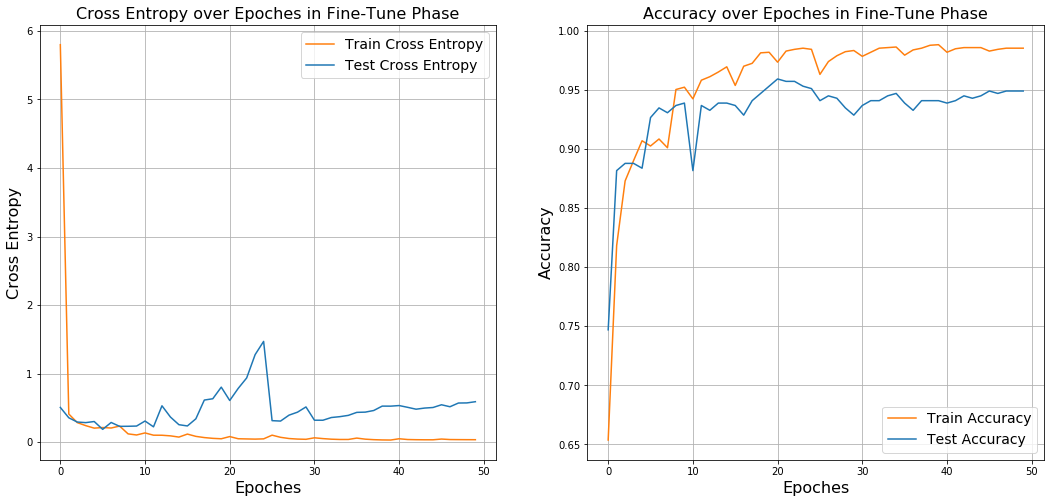

In [17]:
training_losses = losses_finetune['training_losses']
training_accuracy = losses_finetune['training_acces']

testing_losses = losses_finetune['testing_losses']
testing_accuracy = losses_finetune['testing_acces']

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(18, 8))

ax_loss.set_ylabel("Cross Entropy", fontsize=16)
ax_loss.set_xlabel("Epoches", fontsize=16)
ax_loss.set_title("Cross Entropy over Epoches in Fine-Tune Phase", fontsize=16)
ax_loss.plot(training_losses, 'C1', label="Train Cross Entropy")
ax_loss.plot(testing_losses, 'C0', label="Test Cross Entropy")
ax_loss.legend(loc="upper right", prop=dict(size=14))
ax_loss.grid()

ax_acc.set_ylabel("Accuracy", fontsize=16)
ax_acc.set_xlabel("Epoches", fontsize=16)
ax_acc.set_title("Accuracy over Epoches in Fine-Tune Phase", fontsize=16)
ax_acc.plot(training_accuracy, 'C1', label="Train Accuracy")
ax_acc.plot(testing_accuracy, 'C0', label="Test Accuracy")
ax_acc.legend(loc="lower right", prop=dict(size=14))
ax_acc.grid()

fig.show()

#### Use Feedforward to compute class scores for whole dataset
* Get training and testing splits of nodes from model training procedure, adopt feedforward and load trained model and then use nodes being used in previous training procedure to systematically evaluate the model performance.

In [18]:
ft_train_class_socres = GCN.feedforward(train_data, graphs, 
                        model_path='/kaggle/working/finetune_model/finetune_evolve_gcn.ckpt')

ft_test_class_socres  = GCN.feedforward(test_data, graphs, 
                        model_path='/kaggle/working/finetune_model/finetune_evolve_gcn.ckpt')

Loading Model ...
Model is Loaded Successfully



Loading Model ...
Model is Loaded Successfully


#### Random under-sampling for results of majority class to make Receiver Operating Characteristic (ROC) more sensible
* A simple under-sampling technique is to under-sample results of the majority class randomly and uniformly.
* The Receiver operating characteristic (ROC) curve is the typical tool for assessing the performance of machine learning algorithms, but it actually does not measure well for imbalanced data.
* The Receiver operating characteristic (ROC) curves plot FPR vs. TPR. Because TPR only depends on positives (licit transactions), ROC curves do not measure the effects of negatives (illicit transaction). The area under the ROC curve (AUC) assesses overall classification performance. AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.

In [19]:
from random import sample 
train_scores = [x[0] for x in ft_train_class_socres]
test_scores = [x[0] for x in ft_test_class_socres]

train_scores_illicit = [train_scores[i] for i, label in enumerate(train_labels) if label == 0]
train_scores_licit = [train_scores[i] for i, label in enumerate(train_labels) if label == 1]
train_scores_licit_sample = sample(train_scores_licit, len(train_scores_illicit))

test_scores_illicit = [test_scores[i] for i, label in enumerate(test_labels) if label == 0]
test_scores_licit = [test_scores[i] for i, label in enumerate(test_labels) if label == 1]
test_scores_licit_sample = sample(test_scores_licit, len(test_scores_illicit))

y_train_illicit = np.zeros(len(train_scores_illicit))
y_train_licit_sample = np.ones(len(train_scores_licit_sample))
y_test_illicit = np.zeros(len(test_scores_illicit))
y_test_licit_sample = np.ones(len(test_scores_licit_sample))

scores_train_illicit = np.array(train_scores_illicit)
scores_train_licit_sample = np.array(train_scores_licit_sample)
scores_test_illicit = np.array(test_scores_illicit)
scores_test_licit_sample = np.array(test_scores_licit_sample)

scores_train = np.concatenate([scores_train_illicit, scores_train_licit_sample])
scores_test  = np.concatenate([scores_test_illicit,  scores_test_licit_sample])

y_train = np.concatenate([y_train_illicit, y_train_licit_sample])
y_test  = np.concatenate([y_test_illicit,  y_test_licit_sample])

#### Classification output quality evaluations of Fine-Tune Model
* Receiver operating characteristic (ROC) metric to evaluate classifier output quality of retask classification model.
* Precision-Recall (PR) metric to evaluate classifier output quality of retask classification model. Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve.

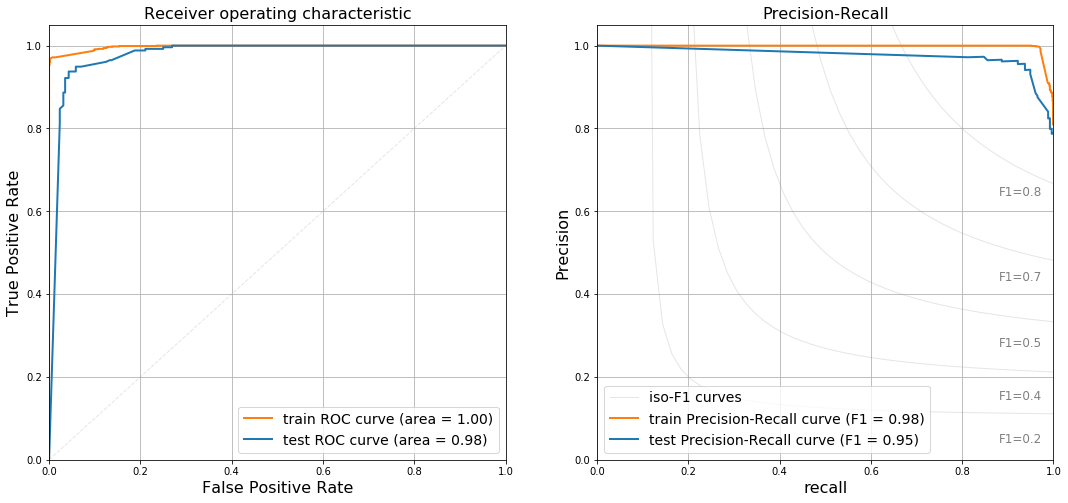

In [20]:
fpr_train, tpr_train, thresholds_train_roc = metrics.roc_curve(y_train+1, scores_train, pos_label=2)
fpr_test, tpr_test, thresholds_test_roc = metrics.roc_curve(y_test+1, scores_test, pos_label=2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

precision_train, recall_train, thresholds_train_pr = metrics.precision_recall_curve(y_train, scores_train)
precision_test, recall_test, thresholds_test_pr = metrics.precision_recall_curve(y_test, scores_test)
f1_train = max(2 * (precision_train * recall_train) / (precision_train + recall_train))
f1_test = max(2 * (precision_test * recall_test) / (precision_test + recall_test))

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 8))
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=16)
ax_roc.set_ylabel('True Positive Rate', fontsize=16)
ax_roc.plot(fpr_train, tpr_train, color='C1',
            lw=2, label='train ROC curve (area = %0.2f)' % roc_auc_train)
ax_roc.plot(fpr_test, tpr_test, color='C0',
            lw=2, label='test ROC curve (area = %0.2f)' % roc_auc_test)
ax_roc.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', alpha=0.2)
ax_roc.set_title('Receiver operating characteristic', fontsize=16)
ax_roc.legend(loc="lower right", prop=dict(size=14))
ax_roc.grid()

lines = []
labels = []
f_scores = np.linspace(0.2, 0.8, num=5)
for f_score in f_scores:
    x = np.linspace(0.001, 1)
    y = f_score * x / (2 * x - f_score)
    l, = ax_pr.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2, lw=1)
    ax_pr.annotate('F1={0:0.1f}'.format(f_score), xy=(0.88, y[45] - 0.07), color='gray', size=12)
lines.append(l)
labels.append('iso-F1 curves')

l, = ax_pr.plot(recall_train, precision_train, color='C1',lw=2)
lines.append(l)
labels.append('train Precision-Recall curve (F1 = %0.2f)' % f1_train)

l, = ax_pr.plot(recall_test, precision_test, color='C0', lw=2)
lines.append(l)
labels.append('test Precision-Recall curve (F1 = %0.2f)' % f1_test)

ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlabel('recall', fontsize=16)
ax_pr.set_ylabel('Precision', fontsize=16)
ax_pr.set_title('Precision-Recall', fontsize=16)
ax_pr.legend(lines, labels, loc="lower left", prop=dict(size=14))
ax_pr.grid()

fig.show()